<a href="https://colab.research.google.com/github/adas-quant/mscfe-gwp1-yieldcurve/blob/arindam-task2/notebooks/02_Task2_YieldCurve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 2 — Yield Curve Modeling

## Objective
- Pick government securities from one country(India)
- Fit Nelson-Siegel model.
- Fit Cubic-Spline model.
- Compare models in terms of fit & interpretation.
- Discuss smoothing vs. ethics.


In [1]:
import pandas as pd

# Example: scrape CCIL tenor-wise yields (they might publish via HTML table)
url = "https://www.ccilindia.com/web/ccil/tenorwise-indicative-yields"
tables = pd.read_html(url)   # this yields a list of DataFrames
for i, tab in enumerate(tables):
    print("Table", i)
    print(tab.head())


Table 0
                    Date Tenor Bucket              Security  YTM (%)
0  2025-10-01 00:00:00.0          91D   91 DTB (02/01/2026)   5.4881
1  2025-10-01 00:00:00.0         182D  182 DTB (03/04/2026)   5.5899
2  2025-10-01 00:00:00.0         364D  364 DTB (02/10/2026)   5.5999
3  2025-10-01 00:00:00.0        1Y-2Y         7.38% GS 2027   5.7975
4  2025-10-01 00:00:00.0        4Y-5Y         6.01% GS 2030   6.1500


In [2]:
import pandas as pd

# CCIL tenor-wise yields URL
url = "https://www.ccilindia.com/web/ccil/tenorwise-indicative-yields"

# Read all HTML tables
tables = pd.read_html(url)

# Pick the first table (the one with yields)
table = tables[0]

# Display full table without truncation
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

print(table)


                     Date Tenor Bucket                Security  YTM (%)
0   2025-10-03 00:00:00.0          91D     91 DTB (02/01/2026)   5.4881
1   2025-10-03 00:00:00.0         182D    182 DTB (03/04/2026)   5.5899
2   2025-10-03 00:00:00.0         364D    364 DTB (02/10/2026)   5.5999
3   2025-10-03 00:00:00.0        1Y-2Y           7.38% GS 2027   5.6511
4   2025-10-03 00:00:00.0        4Y-5Y           6.01% GS 2030   6.1066
5   2025-10-03 00:00:00.0       9Y-10Y           6.33% GS 2035   6.5104
6   2025-10-03 00:00:00.0      13Y-15Y           6.68% GS 2040   6.8047
7   2025-10-03 00:00:00.0      28Y-30Y           7.24% GS 2055   7.1218
8   2025-10-03 00:00:00.0           5Y  7.30% UTTARAKHAND 2032   7.3000
9   2025-10-03 00:00:00.0          10Y          7.37% GOA 2036   7.3700
10  2025-10-03 00:00:00.0          15Y       7.49% KERALA 2040   7.4900


In [3]:
import pandas as pd

# Load CCIL table
url = "https://www.ccilindia.com/web/ccil/tenorwise-indicative-yields"
tables = pd.read_html(url)
df = tables[0]

# Display raw table
df.head(15)


,Date,Tenor Bucket,Security,YTM (%)
0,2025-10-03 00:00:00.0,91D,91 DTB (02/01/2026),5.4881
1,2025-10-03 00:00:00.0,182D,182 DTB (03/04/2026),5.5899
2,2025-10-03 00:00:00.0,364D,364 DTB (02/10/2026),5.5999
3,2025-10-03 00:00:00.0,1Y-2Y,7.38% GS 2027,5.6511
4,2025-10-03 00:00:00.0,4Y-5Y,6.01% GS 2030,6.1066
5,2025-10-03 00:00:00.0,9Y-10Y,6.33% GS 2035,6.5104
6,2025-10-03 00:00:00.0,13Y-15Y,6.68% GS 2040,6.8047
7,2025-10-03 00:00:00.0,28Y-30Y,7.24% GS 2055,7.1218
8,2025-10-03 00:00:00.0,5Y,7.30% UTTARAKHAND 2032,7.3000
9,2025-10-03 00:00:00.0,10Y,7.37% GOA 2036,7.3700


In [4]:
# Keep rows where 'Security' contains 'GS' or 'DTB' (T-Bills)
df_gs = df[df['Security'].str.contains("GS|DTB", case=False, na=False)].copy()

df_gs


,Date,Tenor Bucket,Security,YTM (%)
0,2025-10-03 00:00:00.0,91D,91 DTB (02/01/2026),5.4881
1,2025-10-03 00:00:00.0,182D,182 DTB (03/04/2026),5.5899
2,2025-10-03 00:00:00.0,364D,364 DTB (02/10/2026),5.5999
3,2025-10-03 00:00:00.0,1Y-2Y,7.38% GS 2027,5.6511
4,2025-10-03 00:00:00.0,4Y-5Y,6.01% GS 2030,6.1066
5,2025-10-03 00:00:00.0,9Y-10Y,6.33% GS 2035,6.5104
6,2025-10-03 00:00:00.0,13Y-15Y,6.68% GS 2040,6.8047
7,2025-10-03 00:00:00.0,28Y-30Y,7.24% GS 2055,7.1218


In [5]:
# Mapping tenor buckets to approx years
tenor_map = {
    "182D": 0.5,
    "364D": 1,
    "1Y-2Y": 1,
    "9Y-10Y": 10,
    "10Y": 10,
    "13Y-15Y": 15,
    "15Y": 15,
    "28Y-30Y": 30,
    "30Y": 30,
    "40Y": 40
}

# Add "Years" column
df_gs["Years"] = df_gs["Tenor Bucket"].map(tenor_map)

# Drop rows where we don’t have mapping
df_curve = df_gs.dropna(subset=["Years"]).copy()

df_curve


,Date,Tenor Bucket,Security,YTM (%),Years
1,2025-10-03 00:00:00.0,182D,182 DTB (03/04/2026),5.5899,0.5
2,2025-10-03 00:00:00.0,364D,364 DTB (02/10/2026),5.5999,1.0
3,2025-10-03 00:00:00.0,1Y-2Y,7.38% GS 2027,5.6511,1.0
5,2025-10-03 00:00:00.0,9Y-10Y,6.33% GS 2035,6.5104,10.0
6,2025-10-03 00:00:00.0,13Y-15Y,6.68% GS 2040,6.8047,15.0
7,2025-10-03 00:00:00.0,28Y-30Y,7.24% GS 2055,7.1218,30.0


In [6]:
yield_curve = df_curve[["Date", "Years", "YTM (%)"]].sort_values("Years")

yield_curve


,Date,Years,YTM (%)
1,2025-10-03 00:00:00.0,0.5,5.5899
2,2025-10-03 00:00:00.0,1.0,5.5999
3,2025-10-03 00:00:00.0,1.0,5.6511
5,2025-10-03 00:00:00.0,10.0,6.5104
6,2025-10-03 00:00:00.0,15.0,6.8047
7,2025-10-03 00:00:00.0,30.0,7.1218


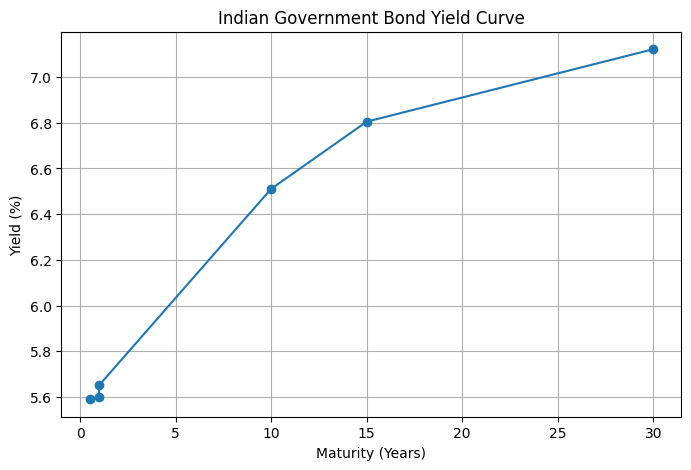

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(yield_curve["Years"], yield_curve["YTM (%)"], marker="o")
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield (%)")
plt.title("Indian Government Bond Yield Curve")
plt.grid(True)
plt.show()
